# Generate INNER calibration

John Curtin & Claire Punturieri  
December 11, 2024

In [ ]:
study <- params$study
cv <- params$cv
algorithms <- params$algorithms
version <- params$version


Function conflicts

In [ ]:

# source
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))


Path

## Functions

In [ ]:
get_brier <- function(split, df){
  
  #filter to split
  probs_split <- df |> 
    filter(split_num == split)

  raw <- probs_split |>
    filter(method == "prob_raw") |> 
    brier_class(label, .pred_Lapse)
  
  logi <- probs_split |>
    filter(method == "prob_logi") |> 
    brier_class(label, .pred_Lapse)
  
  iso <- probs_split |>
    filter(method == "prob_iso") |> 
    brier_class(label, .pred_Lapse)
  
  #beta <- probs_split |>
    #filter(method == "prob_beta") |> 
    #brier_class(label, .pred_Lapse)
  
  brier <- tibble(raw = raw$.estimate, 
                 logi = logi$.estimate, 
                 iso = iso$.estimate) 
  #               beta = beta$.estimate)
  
  #brier <- tibble(raw = raw$.estimate)
  
  return(brier)
}


## Get Probs

In [ ]:
probs <- read_rds(here::here(path_models, str_c("inner_preds_", version, "_", cv, ".rds"))) |> 
  mutate(split_num = 10 * outer_split_num + (inner_split_num - 10)) |> 
  pivot_longer(cols = starts_with("prob"), 
               names_to = "method", 
               values_to = ".pred_Lapse") |>
  glimpse()


Rows: 936,522
Columns: 7
$ id_obs          <int> 602, 602, 602, 603, 603, 603, 604, 604, 604, 605, 605,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…
$ split_num       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ method          <chr> "prob_raw", "prob_iso", "prob_logi", "prob_raw", "prob…
$ .pred_Lapse     <dbl> 0.50047201, 0.07657658, 0.09117982, 0.49951923, 0.0765…

## Brier Scores

In [ ]:
brier <- 1:300 |>
  map(\(split_num) get_brier(split_num, probs)) |> 
  list_rbind()

brier |> head()


# A tibble: 6 × 3
    raw   logi    iso
  <dbl>  <dbl>  <dbl>
1 0.250 0.0578 0.0578
2 0.250 0.0287 0.0268
3 0.250 0.0578 0.0549
4 0.249 0.0647 0.0588
5 0.249 0.107  0.109 
6 0.250 0.0758 0.0766

# A tibble: 1 × 6
  raw_1 raw_2 logi_1 logi_2  iso_1  iso_2
  <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1 0.250 0.250 0.0723 0.0689 0.0736 0.0690

## Explore Plots

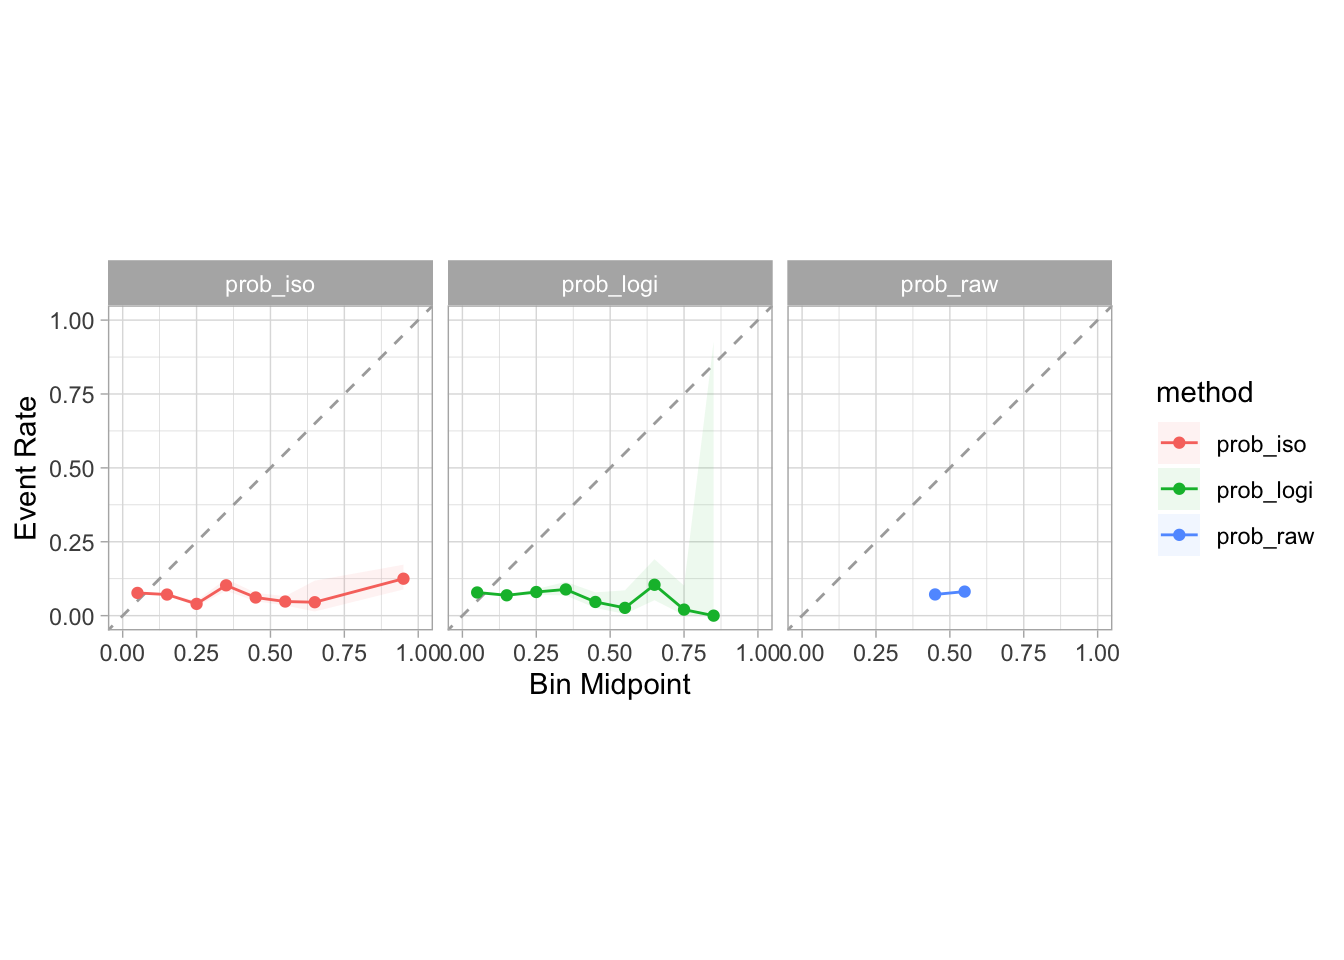

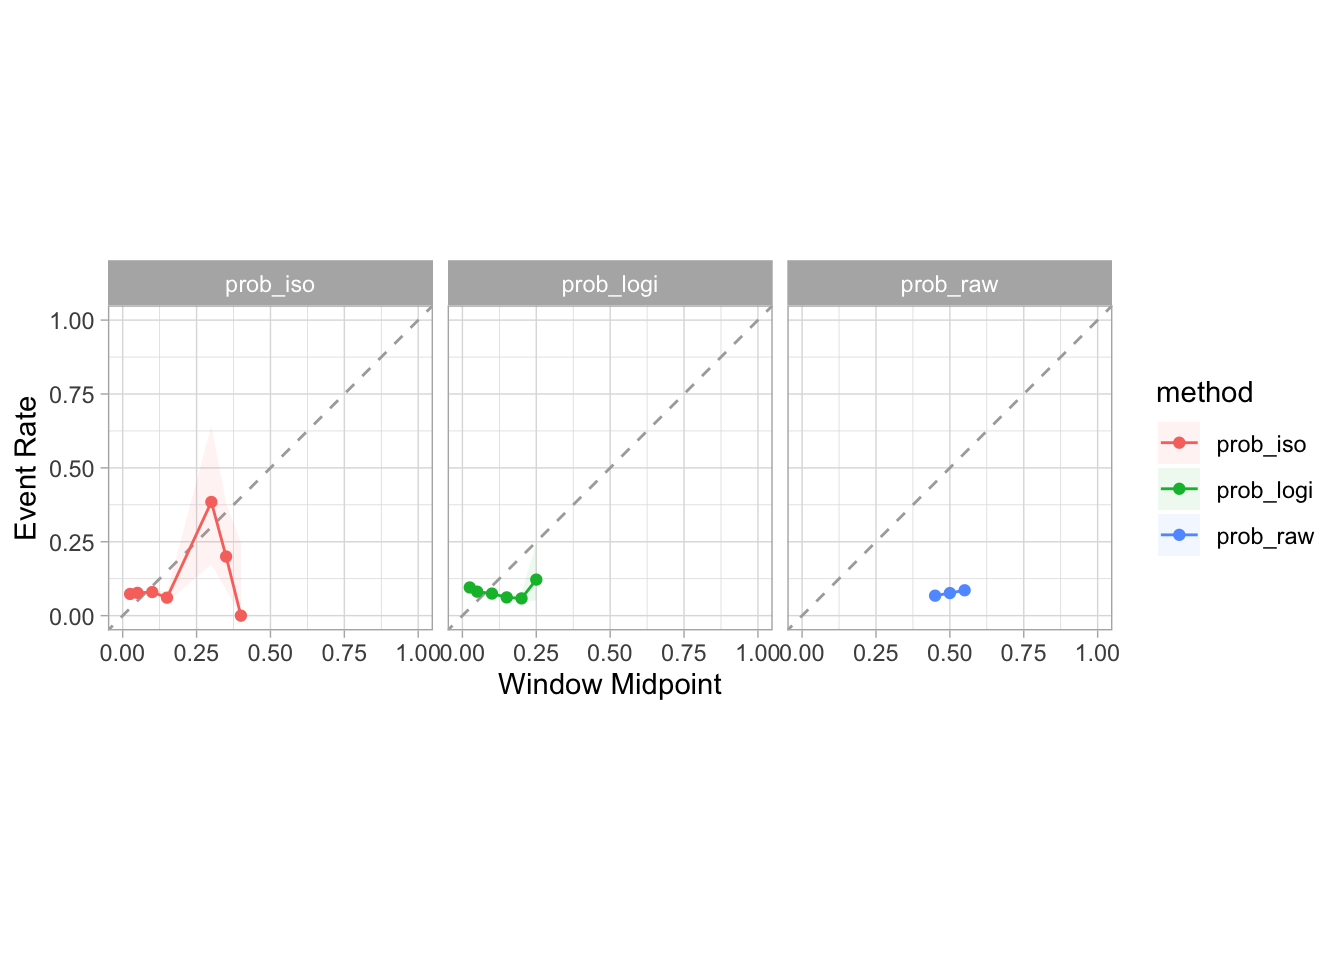

In [ ]:
probs |>
  mutate(.pred_lapse = .pred_Lapse) |> 
  cal_plot_breaks(truth = label, 
                  estimate = .pred_lapse,
                  .by = method)
